In [1]:
from itertools import count
import os
import gc
import time
import pandas as pd
import numpy as np
import zmq
import DRL_pb2

from datetime import date
from agent.main import Agent
from agent.actorcritic import OUNoise
from emulator.main import Account

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from params import *

rSD = '2019-10-1'
rED = '2020-12-1'

import per


time to oSD days
1
(278, 50, 23, 2)
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
277
胜率: 0.5270758122743683
SR: 0.05862992692081995


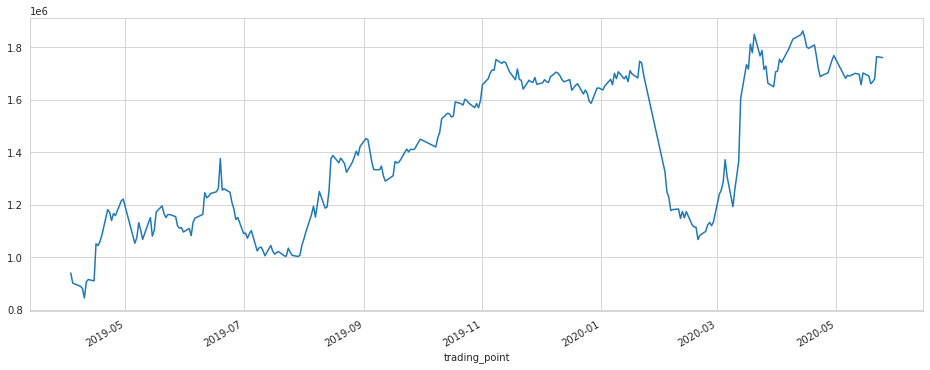

In [2]:
#max_no = 9999
#Instrument_ID = 'ZZ500'
ID = {1:'HS300',2:'SZ50',3:'ZZ500'}
Instrument_ID = ID[2]
env = Account(oSD, rED, Instrument_ID)
#env = Account(oSD, date.today(), Instrument_ID)
state = env.reset()
image_shape = state.shape
print(env.data_observation.shape)
agent_t = Agent(image_shape, ACTION_SIZE)
agent_t.load_model(Instrument_ID, '_best')
#agent_t.load_product_model('HS300')

Full_Size = env.data_observation.shape[0] - 1
print(Full_Size)

for i in range(Full_Size):
    action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
    next_state, reward, done = env.step(action, Instrument_ID)
    state = next_state
    
plt.close()
tmp = env.plot_data()
tmp.iloc[:, 0].plot(figsize=(16, 6))
ratio = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])
print("胜率:", ratio)
print("SR:", sharpe)
env.print_trade_record().to_csv('./track.csv') 

In [3]:
L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
L

0.44765342960288806

In [4]:
W = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
W

0.5270758122743683

In [5]:
model_num = []
models = {}
fronts = {}

env = Account(vSD, '2020-1-1', Instrument_ID)
agent_t = Agent(image_shape, ACTION_SIZE)

for _ in range(0, SMP_NO):
    state = env.reset()
    image_shape = state.shape
    Full_Size = env.data_observation.shape[0] - 1
    
    try:
        agent_t.load_model(Instrument_ID, _)
    except:
        continue
        
    for i in range(Full_Size):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, Instrument_ID)
        state = next_state
    
    tmp = env.plot_data()
    ratio = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
    L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
    sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])*15
    if(sharpe >= 1 and abs(L-0.5) <= 0.15):
        models.update({_:sharpe})
        model_num.append(_)


time to oSD days
0
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2


In [6]:
smp_s = 30
models_1 = sorted(models.items(),key = lambda models:models[1], reverse = True)
tmp_mod = models_1[:smp_s]
for i in tmp_mod:
    fronts[i[0]] = i[1]
model_numbers =[i for i in fronts.keys()][:smp_s]

time to oSD days
0
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2


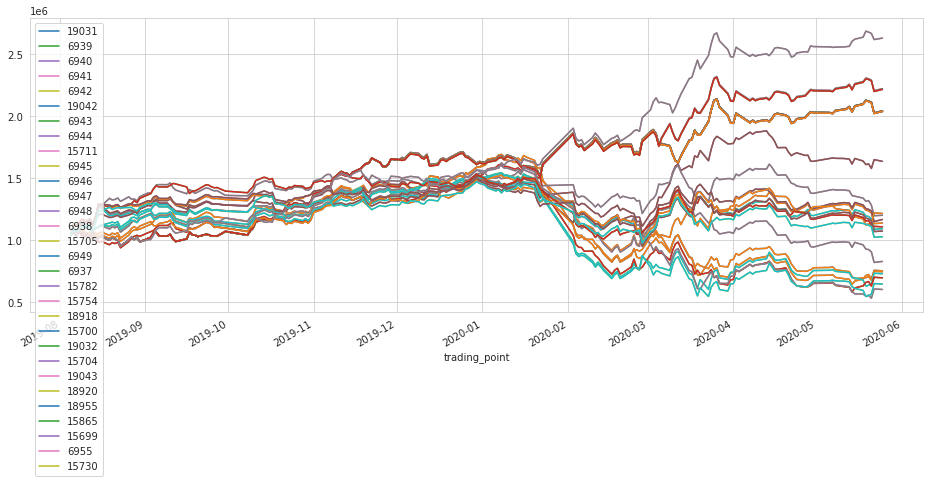

In [7]:
max_no = 0
max_result = 0
max_sharpe = 0
plt_mat = []

env = Account(vSD, rED, Instrument_ID)
agent_t = Agent(image_shape, ACTION_SIZE)

for _ in model_numbers:
    state = env.reset()
    image_shape = state.shape
    Full_Size = env.data_observation.shape[0] - 1
    
    agent_t.load_model(Instrument_ID, _)
    for i in range(Full_Size):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, Instrument_ID)
        state = next_state
    
    tmp = env.plot_data()
    p1,  = plt.plot(tmp.value)
    plt_mat.append(p1)
    tmp.iloc[:, 0].plot(figsize=(16, 6))
    L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
    
    if env.total_value > max_result and abs(L-0.5) < 0.15:
        max_no = _
        max_sharpe = sharpe
        max_result = env.total_value
        
plt.legend(plt_mat, model_numbers ,loc = 'upper left')

time to oSD days
1
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
6955
胜率: 0.5523465703971119
SR: 2.8118397559269974


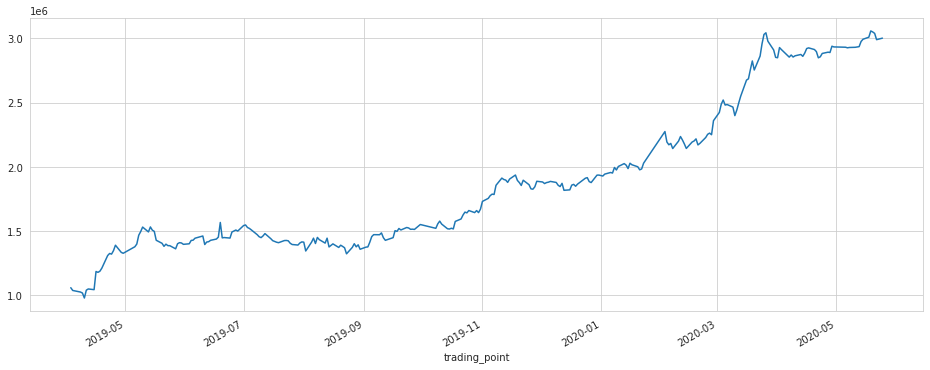

In [8]:
#max_no = 9999
env = Account(oSD, rED, Instrument_ID)
state = env.reset()
agent_t = Agent(image_shape, ACTION_SIZE)
#agent_t.load_model('_best')
agent_t.load_model(Instrument_ID, max_no)
#agent_t.load_product_model('RB')

image_shape = state.shape
Full_Size = env.data_observation.shape[0] - 1

for i in range(Full_Size):
    action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
    next_state, reward, done = env.step(action, Instrument_ID)
    state = next_state
    
print(max_no)
plt.close()
tmp = env.plot_data()
tmp.iloc[:, 0].plot(figsize=(16, 6))
ratio = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])*15
print("胜率:", ratio)
print("SR:", sharpe)
env.print_trade_record().to_csv('./track.csv')

In [9]:
L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
L

0.4043321299638989

In [10]:
W = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
W

0.5523465703971119

time to oSD days
0
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2


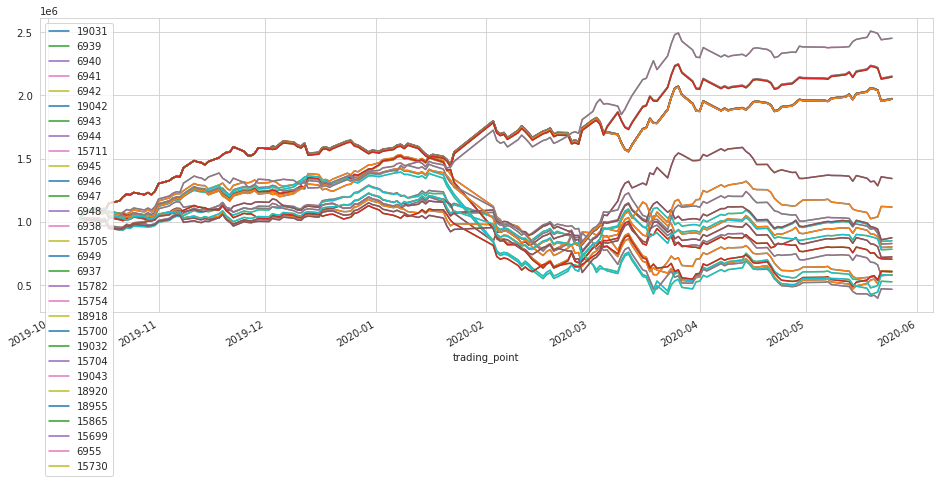

In [11]:
max_no = 0
max_result = 0
max_sharpe = 0
plt_mat = []

env = Account(rSD, date.today().strftime('%Y-%m-%d'), Instrument_ID)
agent_t = Agent(image_shape, ACTION_SIZE)

for _ in model_numbers:
    state = env.reset()
    image_shape = state.shape
    Full_Size = env.data_observation.shape[0] - 1
    
    agent_t.load_model(Instrument_ID, _)
    for i in range(Full_Size):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, Instrument_ID)
        state = next_state
    
    tmp = env.plot_data()
    p1,  = plt.plot(tmp.value)
    plt_mat.append(p1)
    tmp.iloc[:, 0].plot(figsize=(16, 6))
    
        
plt.legend(plt_mat, model_numbers ,loc = 'upper left')

## 

In [12]:
#max_no = 9999
env = Account(oSD, rED, Instrument_ID)
state = env.reset()
agent_t = Agent(image_shape, ACTION_SIZE)
#agent_t.load_model('_best')
agent_t.load_model(Instrument_ID, 3222)
#agent_t.load_product_model('RB')

image_shape = state.shape
Full_Size = env.data_observation.shape[0] - 1

for i in range(Full_Size):
    action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
    next_state, reward, done = env.step(action, Instrument_ID)
    state = next_state
    
print(max_no)
plt.close()
tmp = env.plot_data()
tmp.iloc[:, 0].plot(figsize=(16, 6))
ratio = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])*15
print("胜率:", ratio)
print("SR:", sharpe)
env.print_trade_record().to_csv('./track.csv')

time to oSD days
1
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2


FileNotFoundError: [Errno 2] No such file or directory: './model/SZ50/c_net3222.pkl'

In [ ]:
L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
L